In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn import cluster
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances_argmin

from sklearn.cluster import AgglomerativeClustering, KMeans
import scipy.cluster.hierarchy as shc

In [4]:
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop
from keras import regularizers

Using TensorFlow backend.


In [5]:
# Read the data
features = pd.read_csv('./medical/historical_X.dat', header=None, sep=" ").values
actions = pd.read_csv('./medical/historical_A.dat', header=None, sep=" ").values
outcome = pd.read_csv('./medical/historical_Y.dat', header=None, sep=" ").values
observations = features[:, :128]
labels = features[:,128] + features[:,129]*2

In [6]:
#Start by implementing a model


# -*- Mode: python -*-
# A simple reference recommender
#
#
# This is a medical scenario with historical data. 
#
# General functions
#
# - set_reward
# 
# There is a set of functions for dealing with historical data:
#
# - fit_data
# - fit_treatment_outcome
# - estimate_utiltiy
#
# There is a set of functions for online decision making
#
# - predict_proba
# - recommend
# - observe

from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
import numpy as np


class NNDoctor:
    def __init__(self, 
                 n_actions=1, 
                 n_outcomes=1, 
                 layer_sizes=[64, 16],
                 batch_size=5,
                 epochs=5,
                 optimizer="adam",
                 loss="binary_crossentropy",
                 alpha = 0.001):
        self.n_actions = n_actions
        self.n_outcomes = n_outcomes
        self.reward = self._default_reward
        self.layer_sizes = layer_sizes
        self.batch_size = batch_size
        self.epochs = epochs
        self.optimizer = optimizer
        self.loss = loss
        self.alpha = alpha
        
    def _default_reward(self, action, outcome):
        return -0.1*action + outcome
        
    def get_params(self, deep=True):
        return {k: v for k, v in self.__dict__.items() if not callable(v)}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def predict_proba(self, X):
        return self.model.predict(X)

    def fit(self, X, y):
        self.model = self.build_network(X, y)
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)

    def predict(self, Xtest):
        return self.model.predict(Xtest)
    
    def build_network(self, X, y):
        model = Sequential()
        for layer_size in self.layer_sizes:
            model.add(Dense(layer_size, activation='elu',kernel_regularizer=regularizers.l2(self.alpha)))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss=self.loss,
                      optimizer=self.optimizer,
                      metrics=['accuracy'])
        return model
    
    def score(self, X, y):
        return (self.model.predict(X)**2 - y**2).mean()
    
class NNRecommender:

    #################################
    # Initialise
    #
    # Set the recommender with a default number of actions and outcomes.  This is
    # because the number of actions in historical data can be
    # different from the ones that you can take with your policy.
    model = None
    
    def __init__(self, n_actions, n_outcomes):
        self.n_actions = n_actions
        self.n_outcomes = n_outcomes
        self.reward = self._default_reward

    ## By default, the reward is just equal to the outcome, as the actions play no role.
    def _default_reward(self, action, outcome):
        return -0.1*action + outcome

    # Set the reward function r(a, y)
    def set_reward(self, reward):
        self.reward = reward
    
    ##################################
    # Fit a model from patient data.
    #
    # This will generally speaking be an
    # unsupervised model. Anything from a Gaussian mixture model to a
    # neural network is a valid choice.  However, you can give special
    # meaning to different parts of the data, and use a supervised
    # model instead.
    def fit_data(self, data):
        print("Preprocessing data")
        return None

    def train_model(self, X, a, y):
        param_grid = {'layer_sizes': [[32, 16], [64, 16]],
        'batch_size': [5, 10],
        'epochs': [1, 5],
        'optimizer': ['Adam', 'sgd'],
        'loss': ['mse'],
        'alpha': [0.001, 0.0001]}
        #self.model = GridSearchCV(NNDoctor(), param_grid, cv=10, n_jobs=4)
        self.model = NNDoctor()
        self.model.fit(np.concatenate((X, a), axis=1), y)
        #print(self.model.best_params_)

    ## Fit a model from patient data, actions and their effects
    ## Here we assume that the outcome is a direct function of data and actions
    ## This model can then be used in estimate_utility(), predict_proba() and recommend()
    def fit_treatment_outcome(self, data, actions, outcome):
        print("Fitting treatment outcomes")
        self.train_model(data, actions, outcome)
        return self.model

    ## Estimate the utility of a specific policy from historical data (data, actions, outcome),
    ## where utility is the expected reward of the policy.
    ##
    ## If policy is not given, simply use the average reward of the observed actions and outcomes.
    ##
    ## If a policy is given, then you can either use importance
    ## sampling, or use the model you have fitted from historical data
    ## to get an estimate of the utility.
    ##
    ## The policy should be a recommender that implements get_action_probability()
    def estimate_utility(self, data, actions, outcome, policy=None):
        if policy is None:
            return self.reward(actions, outcome).mean()
        else:
            #predictions_ones = self.model.predict(np.concatenate((data, np.ones(len(data)).reshape(-1,1)), axis = 1))
            #predictions_zeros = self.model.predict(np.concatenate((data, np.zeros(len(data)).reshape(-1,1)), axis = 1))
            #predictions = np.concatenate((predictions_zeros, predictions_ones), axis=1)
            #policy_actions = np.array([policy.get_action_probabilities(x) for x in data])
            policy_actions = np.array([policy.recommend(x) for x in data])
            predicted_outcomes = self.model.predict(np.concatenate((data, policy_actions.reshape(-1,1)), axis=1))
            return self.reward(policy_actions, predicted_outcomes.reshape(1,-1)).mean()
            #print(policy_actions)
            #res_matrix = np.dot(predictions.T, policy_actions)
            #print(res_matrix)
            #return (-0.1*policy_actions.sum() + (res_matrix[0][0] + res_matrix[1][1])) / len(data)

    # Return a distribution of effects for a given person's data and a specific treatment.
    # This should be an numpy.array of length self.n_outcomes
    def predict_proba(self, data, treatment):
        predictions = self.model.predict(np.concatenate((data, [treatment])).reshape(1,-1)).ravel()
        return predictions

    # Return a distribution of recommendations for a specific user datum
    # This should a numpy array of size equal to self.n_actions, summing up to 1
    def get_action_probabilities(self, user_data):
        #print("Recommending")
        predictions = []
        for a in range(self.n_actions):
            estimated_outcome = self.model.predict(np.concatenate((user_data, [a])).reshape(1,-1))[0][0]
            estimated_reward = self.reward(a, estimated_outcome)
            predictions.append(estimated_reward)
        return np.exp(predictions)/np.sum(np.exp(predictions))
    
    def estimate_historic_utility(self, data, actions, outcome):
        estimated_outcome = self.model.predict(np.concatenate((data, actions), axis=1))
        #outcome_prob = 1/(1 + np.exp(0.5-estimated_outcome))
        return self.reward(actions, estimated_outcome).mean()

    # Return recommendations for a specific user datum
    # This should be an integer in range(self.n_actions)
    def recommend(self, user_data):
        return np.argmax(self.get_action_probabilities(user_data))

    # Observe the effect of an action. This is an opportunity for you
    # to refit your models, to take the new information into account.
    def observe(self, user, action, outcome):
        return None

    # After all the data has been obtained, do a final analysis. This can consist of a number of things:
    # 1. Recommending a specific fixed treatment policy
    # 2. Suggesting looking at specific genes more closely
    # 3. Showing whether or not the new treatment might be better than the old, and by how much.
    # 4. Outputting an estimate of the advantage of gene-targeting treatments versus the best fixed treatment
    def final_analysis(self):
        return None


In [7]:
nn = NNRecommender(len(np.unique(actions)), outcome.shape[1])
f_train, f_test, a_train, a_test, o_train, o_test = train_test_split(features, actions, outcome, test_size=.3)
nn.fit_treatment_outcome(f_train, a_train, o_train)

Fitting treatment outcomes





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [8]:
# Exercise 1.1:
# Implemented estimate_utility above
#rec = RandomRecommender(actions.shape[1], actions.shape[1])
nn.estimate_utility(features, actions, outcome)

0.11912

mean utility: 0.1191
Utility std: 0.0033


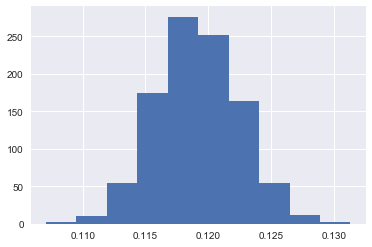

In [14]:
# Exercise 1.2:
# Use bootstrap on the historical dataset to estimate variance of the utility
n = features.shape[0]
num_samples = 1000
utils = []
for i in range(num_samples):
    randlist = np.random.randint(n, size=n)
    sample_features = features[randlist]
    sample_actions = actions[randlist]
    sample_outcome = outcome[randlist]
    utils.append(nn.estimate_utility(sample_features, sample_actions, sample_outcome))
plt.hist(utils)
print("mean utility: {0:.4f}".format(np.mean(utils)))
print("Utility std: {0:.4f}".format(np.std(utils)))

mean utility: 0.1335
Utility std: 0.0029


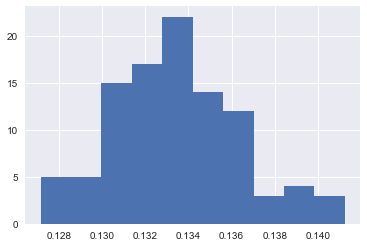

In [15]:
#Exercise 2.1:

n = f_test.shape[0]
num_samples = 100
utils = []
for i in range(num_samples):
    randlist = np.random.randint(n, size=n)
    sample_features = f_test[randlist]
    sample_actions = a_test[randlist]
    sample_outcome = o_test[randlist]
    utils.append(nn.estimate_historic_utility(sample_features, sample_actions, sample_outcome))
plt.hist(utils)
print("mean utility: {0:.4f}".format(np.mean(utils)))
print("Utility std: {0:.4f}".format(np.std(utils)))

In [9]:
nn.estimate_utility(f_test, a_test, o_test)

0.1118

In [10]:
#Excercise 2.2:

nn.estimate_utility(f_test, a_test, o_test, nn)

0.45870542218089105